In [94]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from ensemble import Ensemble

plt.style.use('seaborn-white')
np.random.seed(0)

def plot(y_test, y_score):
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    step_kwargs = {'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {}
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [95]:
data = pd.read_csv('data.csv')
train, test = train_test_split(data, test_size=0.2)
data

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.990,10.38,122.80,1001.0,0.11840,0
1,20.570,17.77,132.90,1326.0,0.08474,0
2,19.690,21.25,130.00,1203.0,0.10960,0
3,11.420,20.38,77.58,386.1,0.14250,0
4,20.290,14.34,135.10,1297.0,0.10030,0
5,12.450,15.70,82.57,477.1,0.12780,0
6,18.250,19.98,119.60,1040.0,0.09463,0
7,13.710,20.83,90.20,577.9,0.11890,0
8,13.000,21.82,87.50,519.8,0.12730,0
9,12.460,24.04,83.97,475.9,0.11860,0


# Regular Decision Tree

precision: 0.921875, recall: 0.8805970149253731


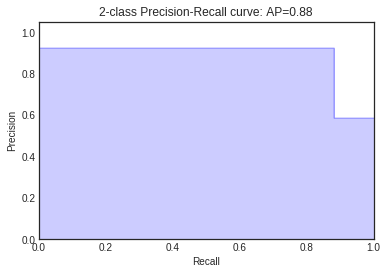

In [96]:
from sklearn.tree import DecisionTreeClassifier

# train
decision_tree = DecisionTreeClassifier(criterion='entropy')
decision_tree.fit(
    np.array(bootstrap.loc[:, train.columns != 'diagnosis']),
    np.array(bootstrap.loc[:, train.columns == 'diagnosis']),
)

# evaluate
y_test = np.array(test.loc[:, train.columns == 'diagnosis'])
y_score = decision_tree.predict(np.array(test.loc[:, train.columns != 'diagnosis']))
precision = precision_score(y_test, y_score)
recall = recall_score(y_test, y_score)
print(f'precision: {precision}, recall: {recall}')
plot(y_test, y_score)

# Ensemble of Decision Trees

precision: 0.9393939393939394, recall: 0.9253731343283582


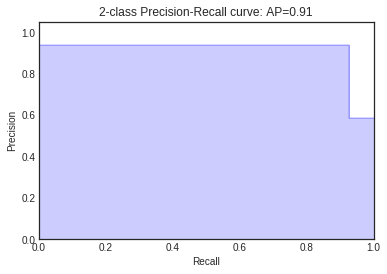

In [100]:
from ensemble import Ensemble, Model, bootstrap

# train
num_children = 100
children = []
for i in range(num_children):
    bootstrapped_data = bootstrap(train)
    child_model = DecisionTreeClassifier(criterion='entropy')
    child_model.fit(
        np.array(bootstrapped_data.loc[:, train.columns != 'diagnosis']),
        np.array(bootstrapped_data.loc[:, train.columns == 'diagnosis']),
    )
    children.append(
        Model(
            name=f'child model {i}',
            call=lambda x: child_model.predict(x)[0]
        )
    )

# build ensemble
bagging_model = Ensemble(name='bagging', children=children, mode='vote')

# evaluate
y_score = np.array([bagging_model([e]) for e in np.array(test.loc[:, train.columns != 'diagnosis'])])
y_test = np.array(test.loc[:, train.columns == 'diagnosis'])
precision = precision_score(y_test, y_score)
recall = recall_score(y_test, y_score)
print(f'precision: {precision}, recall: {recall}')
plot(y_test, y_score)

# Random Forest

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


precision: 0.927536231884058, recall: 0.9552238805970149


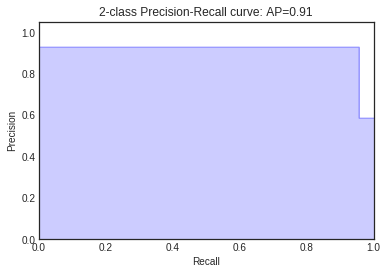

In [104]:
from sklearn.ensemble import RandomForestClassifier

# train
baseline_model = RandomForestClassifier(n_estimators=100, criterion='entropy')
baseline_model.fit(
    np.array(train.loc[:, train.columns != 'diagnosis']),
    np.array(train.loc[:, train.columns == 'diagnosis']),
)

# evaluate
y_test = np.array(test.loc[:, train.columns == 'diagnosis'])
y_score = baseline_model.predict(np.array(test.loc[:, train.columns != 'diagnosis']))
precision = precision_score(y_test, y_score)
recall = recall_score(y_test, y_score)
print(f'precision: {precision}, recall: {recall}')
plot(y_test, y_score)